1. mirror mount positions go from 0 to 1 (or any arbitrary continuous range really)

2. ion responses go from 0 to 100 photons per measurement round (or any arbitrary , small,
integer range)

In [5]:
from typing import List, Dict, Callable
from abc import ABC, abstractmethod
import math
from operator import itemgetter

import scipy.stats as stats
from scipy import optimize

import numpy
import matplotlib.pyplot as plt
from matplotlib.figure import Figure



PickBestPositionT = Callable[[Dict[float, int]], float]


class IonSystem(ABC):
    _max_ion_response = 100

    @abstractmethod
    def move_mirror_to_position(self, pos: float) -> None:
        """
        Move position to pos. 0-1

        """
        ...

    @abstractmethod
    def measure_ion_response(self) -> int:
        """
        Return the ion response 0 to _max_ion_response

        """
        ...

class GaussianIonSystem(IonSystem):
    """
    Ion System the follows a ideal gaussian curve.

    """
    def __init__(self, peak_location: float, variance: float):
        # define constants
        self.peak_location: float = peak_location
        self.variance: float = variance
        self.pos: float = 0.

    @property
    def sigma(self) -> float:
        return math.sqrt(self.variance)

    def move_mirror_to_position(self, pos: float) -> None:
        """
        Move position to pos. 0-1

        """
        self.pos = pos

    def measure_ion_response(self) -> int:
        """
        Return the ion response 0 to _max_ion_response

        """
        return round(
            self._max_ion_response *
            stats.norm.pdf(self.pos, self.peak_location, self.sigma)
            )
    
def gaussian_pick_best_position(ion_responses: Dict[float, int]) -> float:
    """
    This picker assumes a gaussian curve, so we use a fit match to that.
    
    """
    ion_response_list = list(ion_responses.items())
    positions, responses = zip(*ion_response_list)
    first_guess_mean = sorted(ion_response_list, key = itemgetter(1), reverse=True)[0][0]
    ion_response_list.sort(key = itemgetter(1), reverse=True)

    def gaussian(x, amplitude, mean, stddev):
        return amplitude * numpy.exp(-((x - mean) / 4 / stddev)**2)

    (amplitude, mean, stddev), _ = optimize.curve_fit(gaussian, positions, responses)
    return mean

In [6]:
def scan_example(ion_system: IonSystem, pick_best_position: PickBestPositionT) -> float:
    """
    Return the optimal position.

    """
    move_mirror_to_position = ion_system.move_mirror_to_position
    measure_ion_response = ion_system.measure_ion_response
    start = 0
    stop = 1
    step = .01

    ion_responses: Dict[float, int] = {}
    for pos in numpy.arange(start, stop, step):
        move_mirror_to_position(pos)
        ion_response = measure_ion_response()
        ion_responses[pos] = ion_response
    return pick_best_position(ion_responses)



In [10]:
def evaluate_locator(
        cur_ion_sys: IonSystem, 
        pick_best_position: PickBestPositionT,
        expected_position: float,
        ) -> Figure:
    """
    Evaluate how good the method is.
    
    """
    scan_result = scan_example(cur_ion_sys, pick_best_position)

    ion_responses: List[int] = []
    pos_scan = numpy.arange(0, 1, .0001)
    for pos in pos_scan:
        cur_ion_sys.move_mirror_to_position(pos)
        ion_response = cur_ion_sys.measure_ion_response()
        ion_responses.append(ion_response)

    fig, axes = plt.subplots(1,1)
    axes.plot(pos_scan, ion_responses, label="Measured Response")
    axes.axvline(scan_result, color='blue', label='Peak Detect')
    axes.axvline(expected_position, linestyle='dashed', color='gray', label='Peak Actual')
    # dont use percent error because peak could be near zero.
    error = abs(scan_result - expected_position)
    axes.set_title(f'Error: {error:.02f}')
    axes.legend()
    return fig


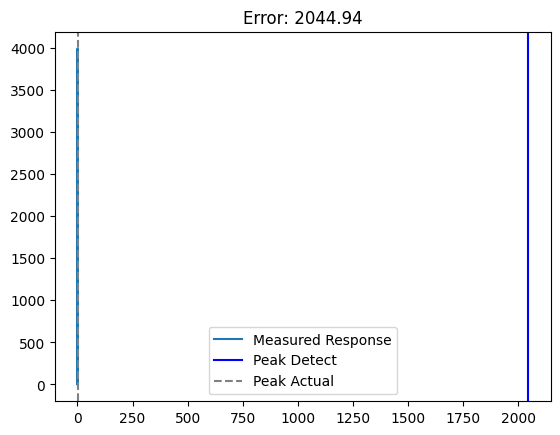

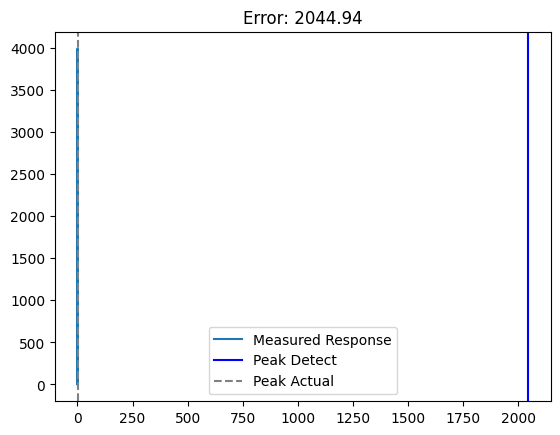

In [27]:
peak_location = .51
variance=.0001
cur_ion_sys = GaussianIonSystem(peak_location=peak_location, variance=variance)

fig = evaluate_locator(
    cur_ion_sys=cur_ion_sys,
    pick_best_position=gaussian_pick_best_position,
    expected_position=peak_location,
    )

fig